In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### NOTE: In the previous homeworks, we had to deal with a number of complications which made the grading process unnecessarily harder.  While some were a result of us not making explicit requests about programming practices, others were a result of students not following explicit instructions.  Most of these are very easy for each of you to address individually, while they end up piling up on our end.  Before submitting, make sure you are adhering to the following rules, which helps us grade your assignment.  Each rule is associated with a penalty.

 * (-1pts) Make sure your notebook only contains the exercises requested in the notebook, and the written homework (if any) is delivered in class in printed form, i.e. don't submit your written homework as part of the notebook.
 * (-1pts) Make sure you are using Python3.  This notebook is already set up to use Python3 (top right corner);  Do not change this.
 * (-1pts) If a method is provided with a specific signature, do not change the signature in any way, or the default values.
 * (-1pts) Don't hard-code your solutions to the specific environments which it is being used on, or the specific hyper-parameters which it is being used on;  Be as general as possible, which means also using ALL the arguments of the methods your are implementing.
 * (-1pts) Make sure your submission file follows the format indicated in blackboard and, most importantly, contains your name.
 * (-1pts) Clean up your code before submitting, i.e. remove all print statements that you've used to develop and debug (especially if it's going to clog up the interface by printing thousands of lines).  Only output whatever is required by the exercise.
 * (-2pts) For technical reasons, plots should be contained in their own cell which should run instantly, separate from cells which perform longer computations.  This notebook is already formatted in such a way, please make sure this remains the case.
 * (-5pts or more) Make sure your notebook runs completely, from start to end, without raising any unintended errors.  After you've made the last edit, Use the option `Kernel -> Restart & Run All` to rerun the entire notebook.  If you end up making ANY edit, re-run everything again.  Always assume any edit you make may have broken your code!  About 10% of the previous homeworks would not run from start to end until something was fixed, which represented a huge effort for the grading process.

# Homework 6: Deep Q-Networks in Pytorch

In this assignment you will implement deep q-learning using Pytorch.

In [4]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import copy
import os
from skimage import io
import ipywidgets as widgets
import more_itertools as mitt
import tqdm

#### Environments

In this notebook, we will implement DQN and run it on four environments which have a consinuous state-space and discrete action-space.  There are:

 * CartPole:  Balance a pole on a moving cart (https://gym.openai.com/envs/CartPole-v1/).
 * Mountain Car:  Gather momentum to climb a hill (https://gym.openai.com/envs/MountainCar-v0/).
 * AcroBot:  A two-link robot needs to swing and reach the area above a line (https://gym.openai.com/envs/Acrobot-v1/).
 * LunarLander:  A spaceship needs to fly and land in the landing spot.  (https://gym.openai.com/envs/LunarLander-v2/).

In [8]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'Breakout': gym.make('Breakout-ram-v0')
#     'mountaincar': gym.make('MountainCar-v0'),
#     'acrobot': gym.make('Acrobot-v1'),
#     'lunarlander': gym.make('LunarLander-v2'),
}


is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
env = envs['cartpole'].unwrapped

In [21]:
env = envs['Breakout'].unwrapped

These environments are particularly cool because they all include a graphical visualization which we can use to visualize our learned policies.  Run the folling cell and click the buttons to run the visualization with a random policy.

In [22]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    env.render()

    while True:
        action = policy(state)
        state, _, done, _ = env.step(action)
        env.render()

        if done:
            break

    env.close()

In [23]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)

    for b in buttons:
        b.disabled = False


buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


## Misc Utilities

Some are provided, some you should implement

### Smoothing

In this homework, we'll do some plotting of noisy data, so here is the smoothing function which was also used in the previous homework.

In [24]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Exercise 1 (5 pts):  Exponential $\epsilon$-Greedy Decay

This time we'll switch from using a linear decay to an exponential decay, defined as
$$\epsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule.

The interface to the scheduler is the same as in the linear case from the previous homework, i.e. it receives the initial value, the final value, and in how many steps to go from initial to final.  Your task is to compute parameters `a` and `b` to make the scheduler work as expected.

In [25]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = np.log(self.value_to / self.value_from) / (self.num_steps - 1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step < 0:
            value = self.value_from
        elif step > self.num_steps - 1:
            value = self.value_to
        else:
            value = self.a * np.exp(self.b * step)
        
        return value


# test code, do not edit


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

### Exercise 2 (10 pts):  Replay Memory

Now we will implement the Replay Memory, the data-structure where we store previous experiences so that we can re-sample and train on them.

In [26]:
# Batch namedtuple, i.e. a class which contains the given attributes

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


### Exercise 3 (20 pts):  Pytorch DQN module

Pytorch is a numeric computation library akin to numpy, which also features automatic differentiation.  This means that the library automatically computes the gradients for many differentiable operations, something we will exploit to train our models without having to program the gradients' code.  There are a few caveats:  sometimes we have to pay explicit attention to whether the operations we are using are implemented by the library (most are), and there are a number of operations which don't play well with automatic differentiation (most notably, in-place assignments).

This library is a tool, and as many tools you'll have to learn how to use it well.  Sometimes not using it well means that your program will crash.  Sometimes it means that your program won't crash but won't be computing the correct outputs.  And sometimes it means that it will compute the correct things, but is less efficient than it could otherwise be.  This library is SUPER popular, and online resources abound, so take your time to learn the basics.  If you're having problems, first try to debug it yourself, also looking up the errors you get online.  You can also use Piazza and the office hours to ask for help with problems.

In the next cell, we inherit from the base class `torch.nn.Module` to implement our DQN module, which takes state-vectors and returns the respective action-values.

In [27]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Exercise 4 (20 pts):  Single batch-update

In [28]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

AttributeError: 'AtariEnv' object has no attribute 'x_threshold'

<Figure size 432x288 with 0 Axes>

### Exercise 5 (20 Points):

In [17]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### Exercise 6 (12 pts): Evaluation of DQN on the 4 environments

#### CartPole

Test your implentation on the cartpole environment.  Training will take much longer than in the previous homeworks, so this time you won't have to find good hyper-parameters, or to train multiple runs.  This cell should take about 60-90 minutes to run.  After training, run the last cell in this notebook to view the policies which were obtained at 0%, 25%, 50%, 75% and 100% of the training.

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [20]:
env =  envs['cartpole']
num_episodes = 5
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [72]:
env = envs['Breakout']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
# num_steps = 1_500_000
num_steps = 5_000_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000
# replay_size = 500_0
# replay_prepopulate_steps = 100_0

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)
# exploration = ExponentialSchedule(1.0, 0.05, 4_000_0)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

NameError: name 'train_dqn' is not defined

###### (3 pts) Plot the returns, lengths and losses obtained while running DQN on the cartpole environment.

Again, plot the raw data and the smoothened data **inside the same plot**, i.e. you should have 3 plots total.

/home/mou/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


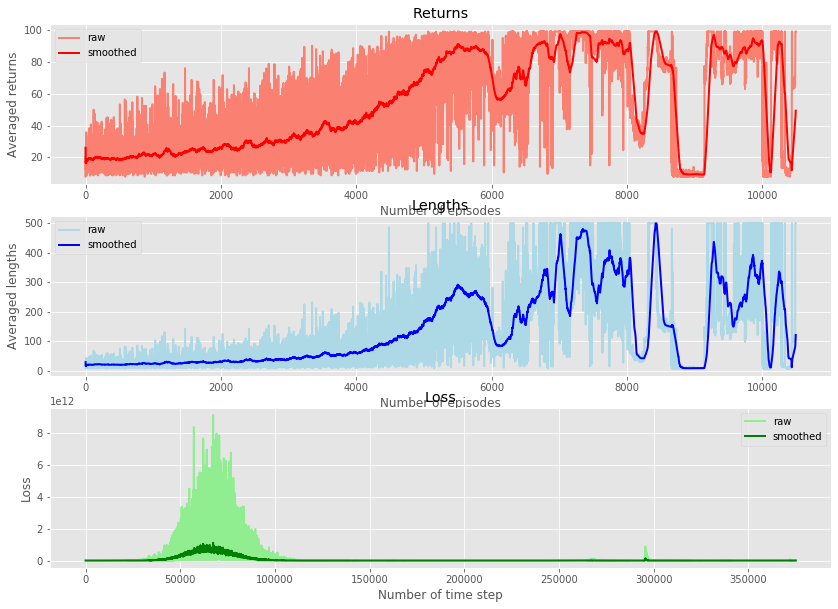

In [13]:
# YOUR PLOTS HERE
epochs = np.arange(len(returns))

# smooth data
smoothed_returns = rolling_average(returns, window_size = 100)
smoothed_lengths = rolling_average(lengths, window_size = 100)
smoothed_losses = rolling_average(losses, window_size = 100)

# plot the returns
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(311)
line_1, = ax1.plot(epochs, returns, 'salmon', linewidth=2.0)
line_2, = ax1.plot(epochs, smoothed_returns, 'r', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged returns')
plt.title('Returns')
plt.legend((line_1, line_2), ('raw', 'smoothed'))

ax2 = fig.add_subplot(312)
line_1, = ax2.plot(epochs, lengths, 'lightblue', linewidth=2.0)
line_2, = ax2.plot(epochs, smoothed_lengths, 'b', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged lengths')
plt.title('Lengths')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
ax3 = fig.add_subplot(313)
epochs = np.arange(len(losses))
line_1, = ax3.plot(epochs, losses, 'lightgreen', linewidth=2.0)
line_2, = ax3.plot(epochs, smoothed_losses, 'g', linewidth=2.0)
plt.xlabel('Number of time step')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
plt.show()

SpaceInvaders

In [ ]:
env = envs['Breakout']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
# num_steps = 1_500_000
num_steps = 5_000_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000
# replay_size = 200_00
# replay_prepopulate_steps = 500_00

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 3_000_000)
# exploration = ExponentialSchedule(1.0, 0.05, 1_000_00)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

###### (3 pts) Plot the returns, lengths and losses obtained while running DQN on the cartpole environment.

Again, plot the raw data and the smoothened data **inside the same plot**, i.e. you should have 3 plots total.

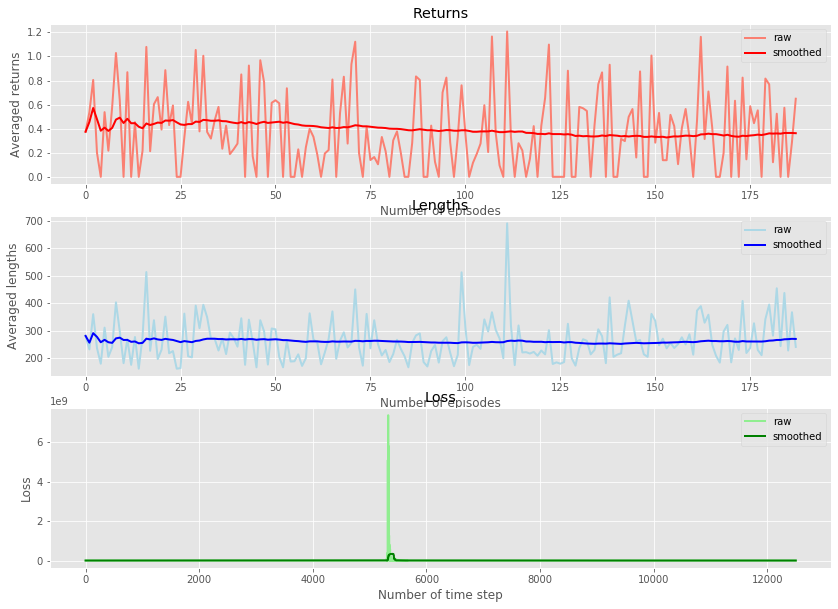

In [28]:
# YOUR PLOTS HERE
epochs = np.arange(len(returns))

# smooth data
smoothed_returns = rolling_average(returns, window_size = 100)
smoothed_lengths = rolling_average(lengths, window_size = 100)
smoothed_losses = rolling_average(losses, window_size = 100)

# plot the returns
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(311)
line_1, = ax1.plot(epochs, returns, 'salmon', linewidth=2.0)
line_2, = ax1.plot(epochs, smoothed_returns, 'r', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged returns')
plt.title('Returns')
plt.legend((line_1, line_2), ('raw', 'smoothed'))

ax2 = fig.add_subplot(312)
line_1, = ax2.plot(epochs, lengths, 'lightblue', linewidth=2.0)
line_2, = ax2.plot(epochs, smoothed_lengths, 'b', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged lengths')
plt.title('Lengths')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
ax3 = fig.add_subplot(313)
epochs = np.arange(len(losses))
line_1, = ax3.plot(epochs, losses, 'lightgreen', linewidth=2.0)
line_2, = ax3.plot(epochs, smoothed_losses, 'g', linewidth=2.0)
plt.xlabel('Number of time step')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
plt.show()

### Visualization of the trained policies!

Run the cell below and push the buttons to view the progress of the policy trained using DQN.

In [29]:
buttons_all = []
for key_env, env in envs.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)
            
            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True
                        
                    render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item())
                    
                    for b in buttons_all:
                        b.disabled = False
                        
                return button_callback
                
            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)
        
        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

Breakout:


### Exercise 7 (20 pts): Analysis

For each environment, describe the progress of the training in terms of the behavior of the agent at each of the 5 phases of training (i.e. 0%, 25%, 50%, 75%, 100%).  Make sure you view each phase a few times so that you can see all sorts of variations.

Say something for each phase (i.e. this exercise is worth 1 point for every phase of every environment).  Start by describing the behavior at phase 0%, then, for each next phase, describe how it differs from the previous one, how it improves and/or how it becomes worse.  At the final phase (100%), also describe the observed behavior in absolute terms, and whether it has achieved optimality.

##### CartPole (5pts)

* 0%) YOUR ANSWER HERE. It this phase, the agent doesn't start to learn anything. Therefore, normally, the episode just terminates immediately because of the pole violates the 15 degree condtion.
* 25%) YOUR ANSWER HERE. At this stage, the agent learns pretty well and almost keeps the car in the center and the pole in the middle.
* 50%) YOUR ANSWER HERE. At this stage, the agent's performance becomes worse. I suspect this is because of the something bad happens to the reply memory and leads to a bad update of the weights. This is also showed in the loss figure, where it has a bump in the middle. The car keeps dives to the left to balance the pole back to the center.
* 75%) YOUR ANSWER HERE. In this phase, the performance becomes better compared to 50%. The cart heads to the left and can keeps the pole back to the center after some movement. However, it still goes too far from the trail center.
* 100%) YOUR ANSWER HERE. In this phase, the performance is better. However, the car perform well at the begining,then suddenly it has a big acceleration speed to the right. This behaviour leads to a big change of the angle of the pole to the left. However, the general ability for the car to keep the angle limitation is good. Sometimes, it can perform really well.